This notebook plays around with the default outputs of the pagoo class in R, applying them to visualize a k<sub>aa</sub>-mer metapangenome.

In [4]:
setwd("..")

In [3]:
library(dplyr)
library(readr)
library(pagoo)

## Functions

In [6]:
read_long_sketch_table_as_pagoo <- function(path, threshold = 2000){
  sketch_table <- read_csv(path, show_col_types = F)
  
  # filter samples that don't have enough k-mers for the species
  sketch_table_grp <- sketch_table %>%
    group_by(acc) %>%
    tally()

  print(sketch_table_grp)
  
  keep <- sketch_table_grp %>%
    filter(n > threshold)
  
  sketch_table <- sketch_table %>%
    filter(acc %in% keep$acc) %>%
    select(gene    = minhash, 
           org     = acc,
           cluster = minhash) 
  p <- pagoo(data = as.data.frame(sketch_table))
  return(p)
}

In [7]:
species_string <- "GCF_009025805.1-s__Phocaeicola_vulgatus"
pg <- read_long_sketch_table_as_pagoo(paste0("outputs/nbhd_sketch_tables_species/",
                                             species_string, "_long.csv"))

# A tibble: 12 × 2
   acc                                                  n
   <chr>                                            <int>
 1 HSM67VF9.GCF_009025805.1.s__Phocaeicola_vulgatus 17158
 2 HSM67VFD.GCF_009025805.1.s__Phocaeicola_vulgatus 16658
 3 HSM67VFJ.GCF_009025805.1.s__Phocaeicola_vulgatus 15713
 4 HSM6XRQB.GCF_009025805.1.s__Phocaeicola_vulgatus 18966
 5 HSM6XRQI.GCF_009025805.1.s__Phocaeicola_vulgatus 18147
 6 HSM6XRQK.GCF_009025805.1.s__Phocaeicola_vulgatus 20036
 7 HSM6XRQM.GCF_009025805.1.s__Phocaeicola_vulgatus 21421
 8 HSM6XRQO.GCF_009025805.1.s__Phocaeicola_vulgatus 20649
 9 HSM7CYY7.GCF_009025805.1.s__Phocaeicola_vulgatus 15010
10 HSM7CYY9.GCF_009025805.1.s__Phocaeicola_vulgatus 15656
11 HSM7CYYB.GCF_009025805.1.s__Phocaeicola_vulgatus  1044
12 HSM7CYYD.GCF_009025805.1.s__Phocaeicola_vulgatus 16262


Checking class.

Checking dimnames.

Creating gid (gene ids).

Creating panmatrix.

Populating class.



## Try basic pagoo plots

In [8]:
pg_organisms <- gsub(species_string, "", as.character(pg$organisms$org))

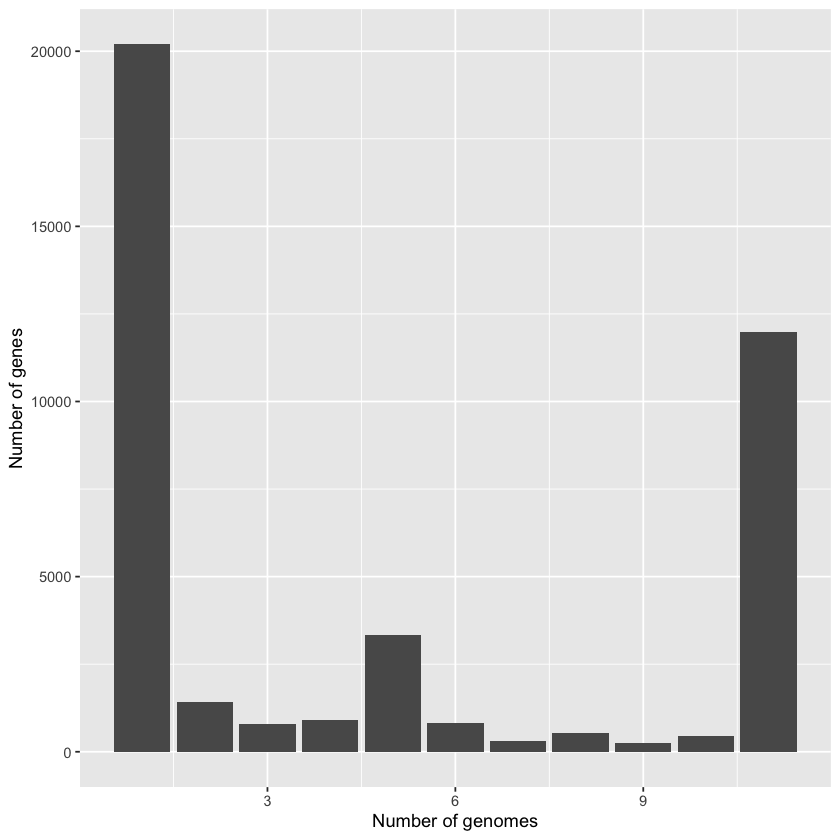

In [10]:
pg$gg_barplot()

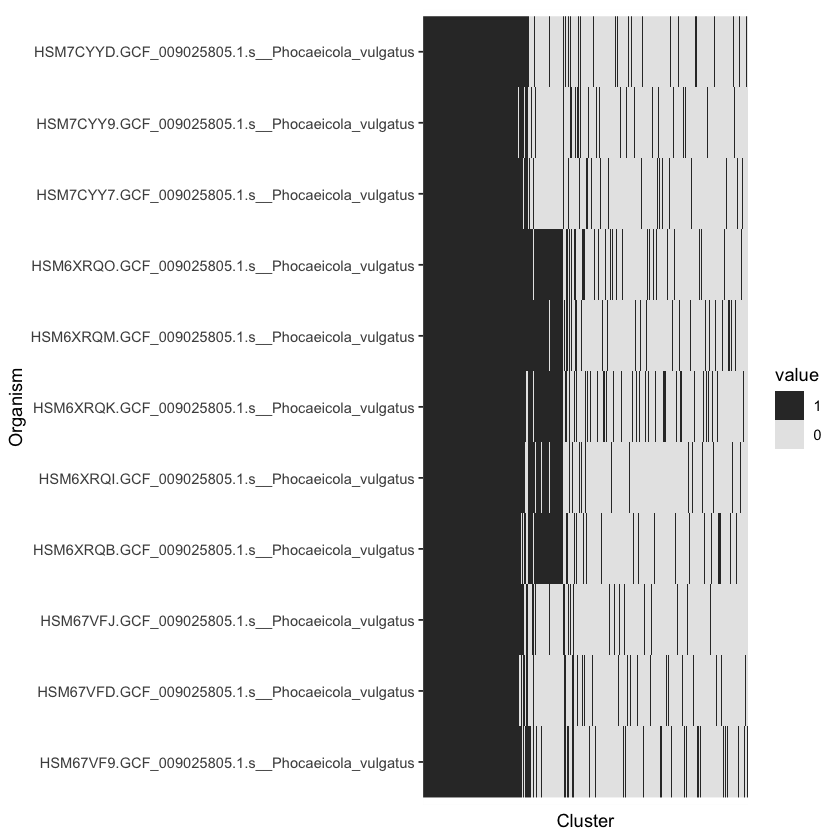

In [11]:
pg$gg_binmap()

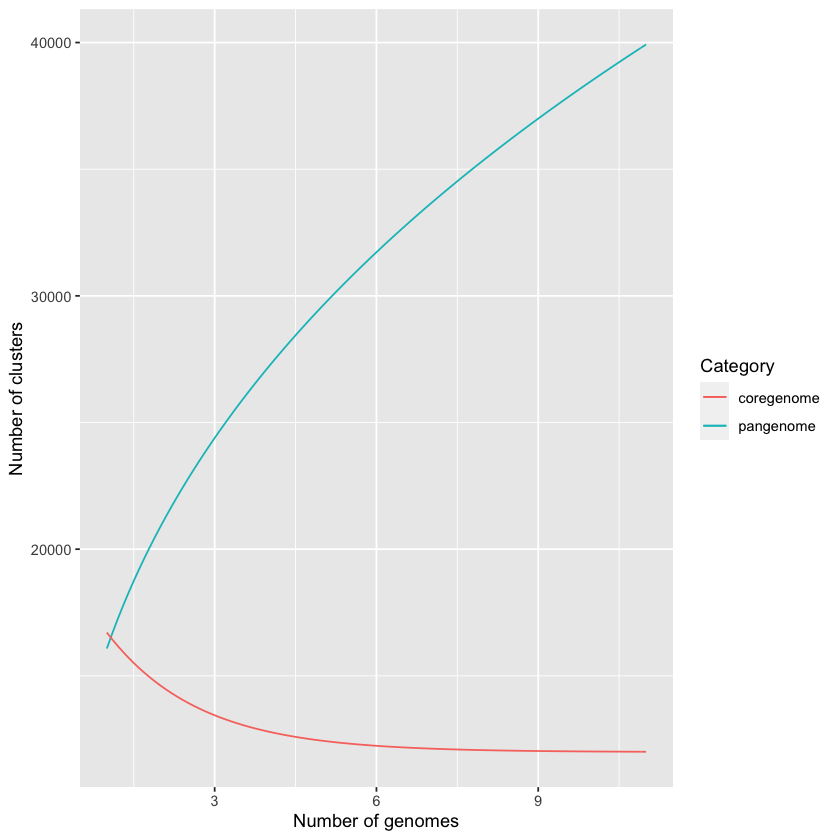

In [12]:
pg$gg_curves()

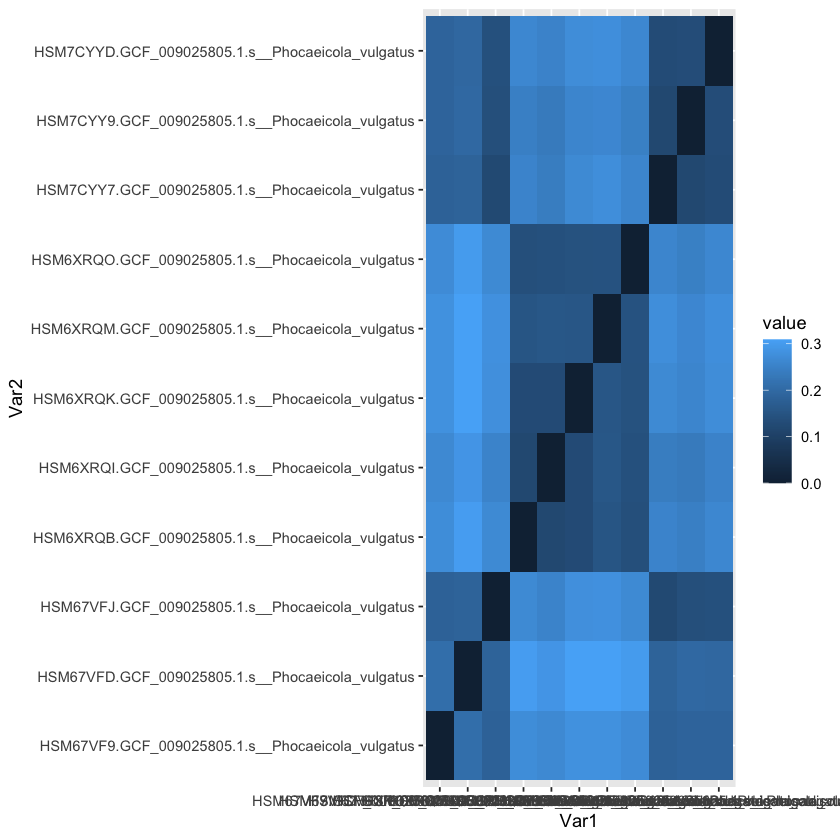

In [13]:
pg$gg_dist()

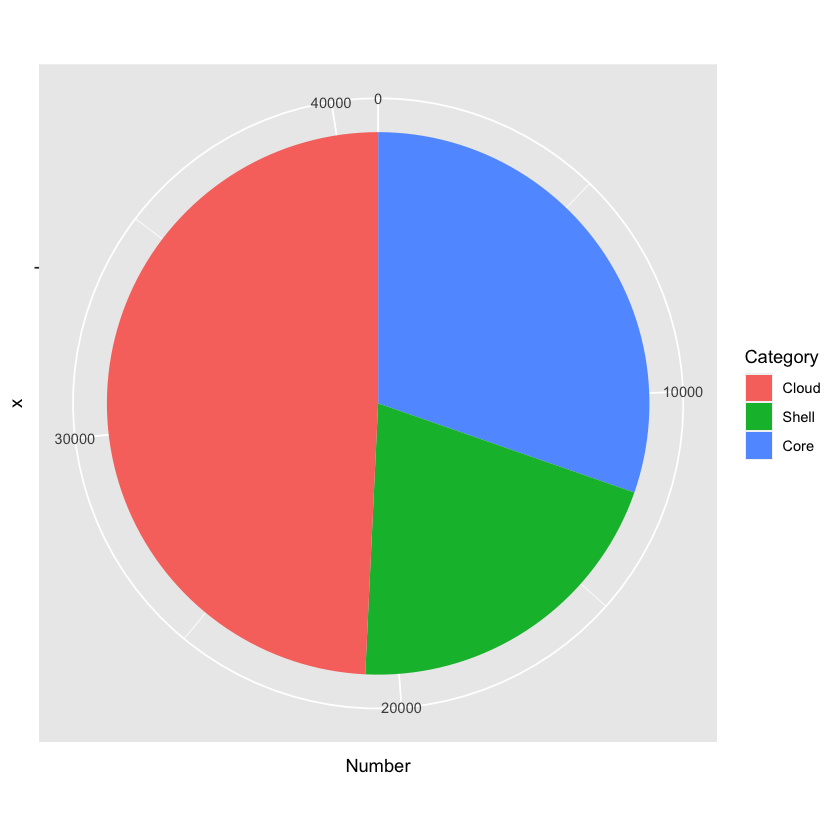

In [14]:
pg$gg_pie()

## read in and format hmp metadata

In [16]:
destfile <- "inputs/hmp2_metadata.csv"
url <- "https://ibdmdb.org/tunnel/products/HMP2/Metadata/hmp2_metadata.csv"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto")
}
hmp_metadata <- read_csv(destfile, show_col_types =F)

h4017 <- hmp_metadata %>%
  select(data_id = "External ID", data_type,
         week_num, diagnosis, antibiotics = "Antibiotics") %>%
  filter(data_type == "metagenomics") %>%
  filter(data_id %in% c('HSM67VF9', 'HSM67VFD', 'HSM67VFJ', 'HSM6XRQB',
                        'HSM6XRQI', 'HSM6XRQK', 'HSM6XRQM', 'HSM6XRQO',
                        'HSM7CYY7', 'HSM7CYY9', 'HSM7CYYB', 'HSM7CYYD'))

h4017 <- h4017 %>%
  mutate(org = paste0(data_id, ".", species_string)) %>%
  filter(data_id %in% pg_organisms)

Warning message:
“One or more parsing issues, see `problems()` for details”


In [24]:
# add metadata
pg$add_metadata(map = "org", as.data.frame(h4017))

Warning message in FUN(X[[i]], ...):
“Column 'data_id' already exists, overwriting.”
Warning message in FUN(X[[i]], ...):
“Column 'data_type' already exists, overwriting.”
Warning message in FUN(X[[i]], ...):
“Column 'week_num' already exists, overwriting.”
Warning message in FUN(X[[i]], ...):
“Column 'diagnosis' already exists, overwriting.”
Warning message in FUN(X[[i]], ...):
“Column 'antibiotics' already exists, overwriting.”


In [27]:
pg

<PgR6M>
  Inherits from: <PgR6>
  Public:
    add_metadata: function (map = "org", data) 
    cg_exp_decay_fit: function (raref, pcounts = 10, ...) 
    clone: function (deep = FALSE) 
    cloud_clusters: active binding
    cloud_genes: active binding
    clusters: active binding
    core_clusters: active binding
    core_genes: active binding
    core_level: active binding
    dist: function (method = "bray", binary = FALSE, diag = FALSE, upper = FALSE, 
    drop: function (x) 
    dropped: active binding
    genes: active binding
    gg_barplot: function () 
    gg_binmap: function () 
    gg_curves: function (what = c("pangenome", "coregenome"), ...) 
    gg_dist: function (method = "bray", ...) 
    gg_pca: function (colour = NULL, ...) 
    gg_pie: function () 
    initialize: function (data, org_meta, cluster_meta, core_level = 95, sep = "__", 
    organisms: active binding
    pan_matrix: active binding
    pan_pca: function (center = TRUE, scale. = FALSE, ...) 
    pg_power_law

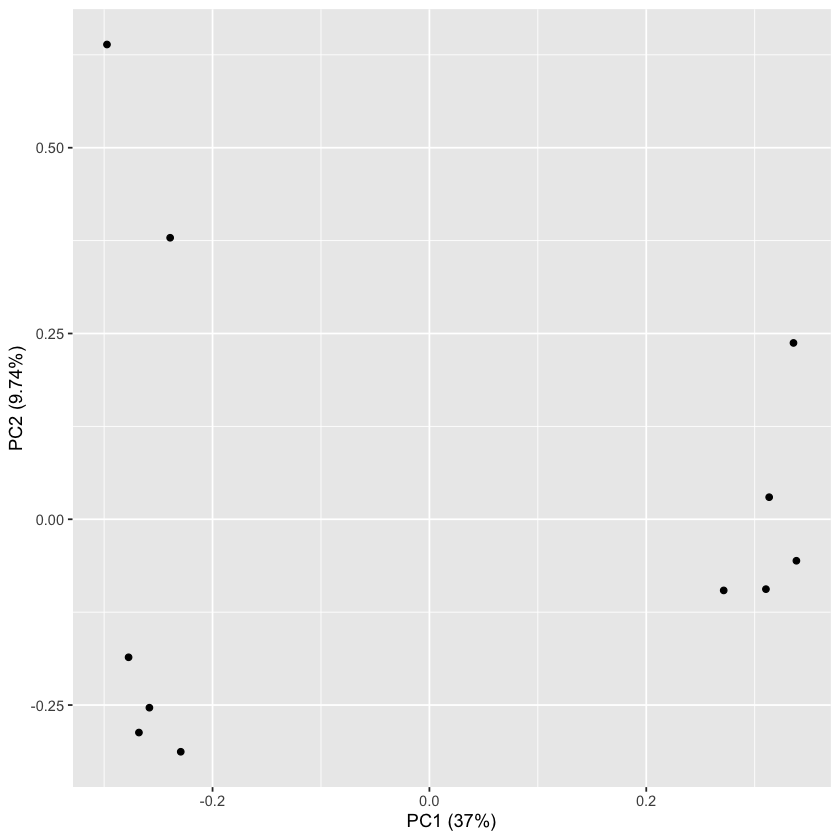

In [29]:
pg$gg_pca()

In [19]:
# try and re color binmap
gg_binmap = function(){
  tpm <- t(pg$pan_matrix)
  tpm[which(tpm > 0, arr.ind = TRUE)] <- 1L
  bm <- as.data.frame(tpm)
  or <- order(rowSums(bm), decreasing = TRUE)
  lvls <- rownames(bm)[or]
  bm$Cluster <- factor(rownames(bm), levels = lvls)
  bm <- reshape2::melt(bm, 'Cluster')
  bm$value <- factor(bm$value, levels = c(1, 0))
  bm <- left_join(bm, h4017, by = c("variable" = "org"))
  bm$value_abx <- paste0(bm$value, "_", bm$antibiotics)
  bm$value_abx <- factor(bm$value_abx, levels = c("0_No", "1_No", "0_Yes",  "1_Yes"))
  colnames(bm)[which(colnames(bm) == 'variable')] <- "Organism"
  ggplot(bm, aes(Cluster, as.factor(week_num), fill=value_abx)) +
    geom_raster() +
    theme(axis.ticks.x = element_blank(),
          axis.text.x = element_blank(),
          plot.title = element_text(face = "italic")) +
    #scale_fill_grey(start = .2, end = .9)
    scale_fill_brewer(palette = "Paired") +
    labs(x = "protein k-mer", y = "week number", fill = "antibiotics\n& presence",
         title = species_string)
}

In [30]:
# Summary of pagoo results
# Phocaeicola vulgatus
# core genome is stable across abx administration, but set of genes disappears with second round of abx.
pg$summary_stats

DataFrame with 4 rows and 2 columns
     Category    Number
  <character> <integer>
1       Total     41005
2        Core     12437
3       Shell      8376
4       Cloud     20192